In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

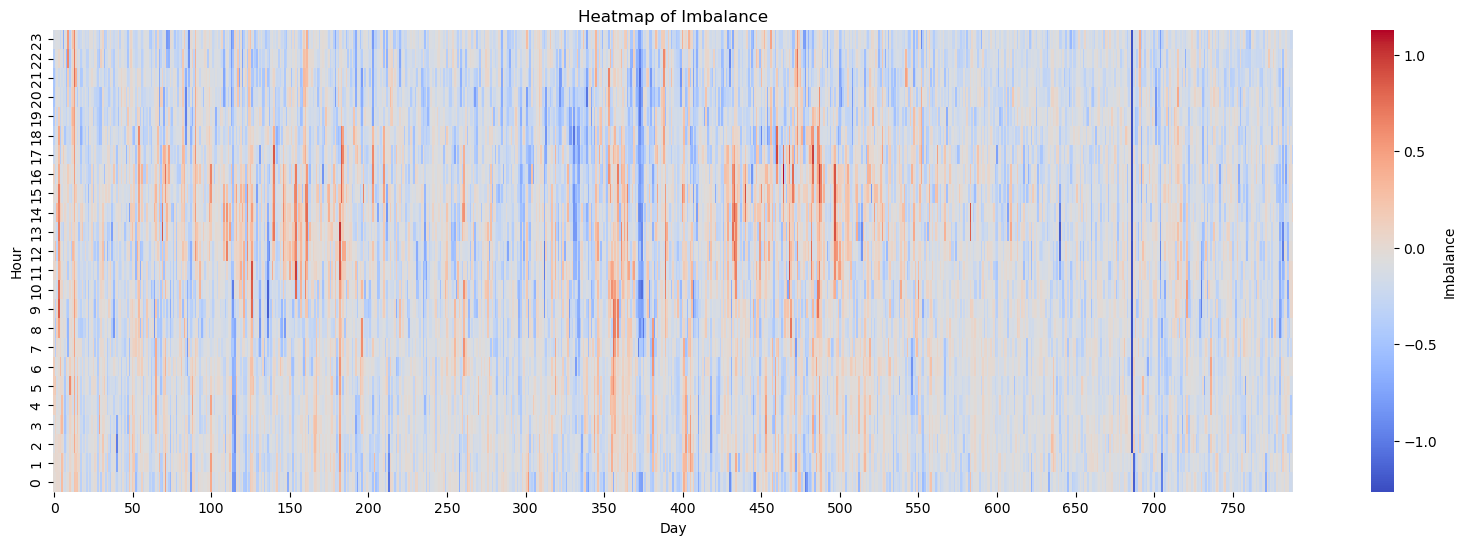

In [36]:
X = np.load("../data/X.npy")

condition = X[:, :3, :]
target = X[:, 3, :]

cond_tensor = torch.tensor(condition, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

dataset = TensorDataset(cond_tensor, target_tensor)

cond_dim = 3 * 24
target_dim = 24
latent_dim = 16

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=2**8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2**8, shuffle=False)


plt.figure(figsize=(20, 6))
ax = sns.heatmap(target.T, cmap='coolwarm', cbar_kws={'label': 'Imbalance'}, xticklabels=50)
ax.set_xlabel("Day")
ax.set_ylabel("Hour")
plt.title("Heatmap of Imbalance")
plt.gca().invert_yaxis()
plt.show()

In [37]:
class MLPBlock(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.1):
        super(MLPBlock, self).__init__()
        inner_dim = 4 * input_dim 
        self.layer_norm = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, input_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        residual = x
        x = self.layer_norm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x + residual

In [38]:
class Encoder(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(cond_dim + target_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
    
    def forward(self, cond, target):
        x = torch.cat([cond, target], dim=1)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [39]:
class Decoder(nn.Module):
    def __init__(self, cond_dim, latent_dim, target_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(cond_dim + latent_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, target_dim)
    
    def forward(self, cond, z):
        x = torch.cat([cond, z], dim=1)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        out = self.fc3(h)
        return out

In [40]:
class CVAE(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(cond_dim, target_dim, latent_dim)
        self.decoder = Decoder(cond_dim, latent_dim, target_dim)
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, cond, target):
        mu, logvar = self.encoder(cond, target)
        z = self.reparameterize(mu, logvar)
        recon_target = self.decoder(cond, z)
        return recon_target, mu, logvar

In [41]:
def loss_function(recon_target, target, mu, logvar):
    recon_loss = F.mse_loss(recon_target, target, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(cond_dim, target_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [44]:
num_epochs = 2**12

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_cond, batch_target in train_loader:
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
        
        optimizer.zero_grad()
        recon_target, mu, logvar = model(batch_cond_flat, batch_target)
        loss = loss_function(recon_target, batch_target, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * batch_cond.size(0)
    
    avg_train_loss = train_loss / len(train_dataset)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_cond, batch_target in val_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            recon_target, mu, logvar = model(batch_cond_flat, batch_target)
            loss = loss_function(recon_target, batch_target, mu, logvar)
            val_loss += loss.item() * batch_cond.size(0)
    avg_val_loss = val_loss / len(val_dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/4096, Train Loss: 0.0301, Val Loss: 0.0553
Epoch 2/4096, Train Loss: 0.0300, Val Loss: 0.0558
Epoch 3/4096, Train Loss: 0.0300, Val Loss: 0.0559
Epoch 4/4096, Train Loss: 0.0301, Val Loss: 0.0558
Epoch 5/4096, Train Loss: 0.0300, Val Loss: 0.0561
Epoch 6/4096, Train Loss: 0.0301, Val Loss: 0.0562
Epoch 7/4096, Train Loss: 0.0301, Val Loss: 0.0557
Epoch 8/4096, Train Loss: 0.0299, Val Loss: 0.0563
Epoch 9/4096, Train Loss: 0.0301, Val Loss: 0.0564
Epoch 10/4096, Train Loss: 0.0299, Val Loss: 0.0558
Epoch 11/4096, Train Loss: 0.0301, Val Loss: 0.0566
Epoch 12/4096, Train Loss: 0.0299, Val Loss: 0.0560
Epoch 13/4096, Train Loss: 0.0298, Val Loss: 0.0558
Epoch 14/4096, Train Loss: 0.0299, Val Loss: 0.0558
Epoch 15/4096, Train Loss: 0.0299, Val Loss: 0.0562
Epoch 16/4096, Train Loss: 0.0300, Val Loss: 0.0559
Epoch 17/4096, Train Loss: 0.0299, Val Loss: 0.0556
Epoch 18/4096, Train Loss: 0.0299, Val Loss: 0.0560
Epoch 19/4096, Train Loss: 0.0299, Val Loss: 0.0560
Epoch 20/4096, Train 

In [45]:
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)
    recon_target, _, _ = model(sample_cond_flat, sample_target)
    print("\nValidation Sample:")
    print("True Imbalance (first sample):")
    print(sample_target[0])
    print("Predicted Imbalance (random sample):")
    print(recon_target[0])

    


Validation Sample:
True Imbalance (first sample):
tensor([-0.1780, -0.1910, -0.1290, -0.0060,  0.0380,  0.0660,  0.0610,  0.0080,
        -0.1040, -0.1560, -0.1780, -0.0490,  0.1990,  0.7140,  0.6460,  0.6220,
         0.6880,  0.8590,  0.3920,  0.0920,  0.0320,  0.0660, -0.1000, -0.1660])
Predicted Imbalance (random sample):
tensor([-0.0753, -0.0612, -0.1100, -0.1756, -0.1469, -0.1176, -0.0930, -0.0239,
         0.0344,  0.1518,  0.2146,  0.2001,  0.1650,  0.2026,  0.1266,  0.0795,
         0.0955,  0.0560,  0.0876, -0.0153, -0.0202, -0.0670, -0.1195, -0.1256])


In [46]:
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)
    
    mu, logvar = model.encoder(sample_cond_flat, sample_target)
    recon_target = model.decoder(sample_cond_flat, mu)
    
    print("\nValidation Samples and Predictions (First 5):")
    for i in range(5):
        print(f"\nSample {i+1} True Imbalance:")
        print(sample_target[i])
        print(f"Sample {i+1} Predicted Imbalance:")
        print(recon_target[i])



Validation Samples and Predictions (First 5):

Sample 1 True Imbalance:
tensor([-0.1780, -0.1910, -0.1290, -0.0060,  0.0380,  0.0660,  0.0610,  0.0080,
        -0.1040, -0.1560, -0.1780, -0.0490,  0.1990,  0.7140,  0.6460,  0.6220,
         0.6880,  0.8590,  0.3920,  0.0920,  0.0320,  0.0660, -0.1000, -0.1660])
Sample 1 Predicted Imbalance:
tensor([-0.0737, -0.0595, -0.1082, -0.1746, -0.1451, -0.1158, -0.0908, -0.0218,
         0.0376,  0.1545,  0.2171,  0.2007,  0.1659,  0.2044,  0.1283,  0.0797,
         0.0962,  0.0556,  0.0864, -0.0159, -0.0217, -0.0692, -0.1198, -0.1237])

Sample 2 True Imbalance:
tensor([-0.3850, -0.2600, -0.2690, -0.0210,  0.0050, -0.0050,  0.0020, -0.0730,
        -0.0210, -0.0130,  0.0120,  0.0600, -0.0030,  0.0080, -0.0540,  0.0580,
         0.0370,  0.0740,  0.0590,  0.1650,  0.2840,  0.2190,  0.1800,  0.1040])
Sample 2 Predicted Imbalance:
tensor([-0.5795, -0.4643, -0.4069, -0.4266, -0.4267, -0.4117, -0.3310, -0.2668,
        -0.2118, -0.1675, -0.2011, -0.

In [47]:
num_samples = 16
samples = []
sample_cond, sample_target = next(iter(val_loader))
sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
sample_target = sample_target.to(device)

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        mu, logvar = model.encoder(sample_cond_flat, sample_target)
        z = model.reparameterize(mu, logvar)
        recon_target = model.decoder(sample_cond_flat, z)
        samples.append(recon_target.cpu().numpy())


In [48]:
samples[0].tolist()

[[-0.07113052159547806,
  -0.056604739278554916,
  -0.1060742512345314,
  -0.17375849187374115,
  -0.14417029917240143,
  -0.11568686366081238,
  -0.09109209477901459,
  -0.021731313318014145,
  0.038087137043476105,
  0.15546534955501556,
  0.2172231376171112,
  0.20065811276435852,
  0.16592124104499817,
  0.20451094210147858,
  0.1292130947113037,
  0.08030346035957336,
  0.09679862856864929,
  0.0548131950199604,
  0.08642963320016861,
  -0.014664512127637863,
  -0.021684324368834496,
  -0.0686464011669159,
  -0.12015359848737717,
  -0.1233014464378357],
 [-0.576833963394165,
  -0.46188780665397644,
  -0.40483909845352173,
  -0.4250207245349884,
  -0.425816148519516,
  -0.4112553596496582,
  -0.3314652740955353,
  -0.2668391466140747,
  -0.21219520270824432,
  -0.16771601140499115,
  -0.20056048035621643,
  -0.15394313633441925,
  -0.11708220839500427,
  -0.08085831254720688,
  -0.051055632531642914,
  -0.06230657920241356,
  -0.2524183988571167,
  -0.3701164722442627,
  -0.3918130

In [62]:
import plotly.graph_objects as go
batch_index = 13
traces = []
traces.append({"y": sample_target.cpu().numpy()[batch_index], "name": "Target"})
for i, sample in enumerate(samples):
    traces.append({"y": sample[batch_index], "name": f"Sample {i}"})

go.Figure(data=traces)